    Greedy Search
        Definition: Always selects the most probable next token.
        Pros: Fast and efficient.
        Cons: Short-sighted and can miss better sequences.
        Example Implementation

    Beam Search
        Definition: Considers multiple beams (sequences) at each step and keeps the top n beams based on their cumulative probabilities.
        Pros: Balances between probability and sequence quality.
        Cons: Computationally expensive and can still miss diverse sequences.
        Example Implementation

    Top-k Sampling
        Definition: Randomly selects the next token from the top k most probable tokens.
        Pros: Introduces randomness, which can lead to more creative outputs.
        Cons: Can produce less coherent sequences.
        Example Implementation

    Nucleus Sampling (Top-p Sampling)
        Definition: Chooses tokens from a nucleus of tokens whose cumulative probability exceeds a threshold p.
        Pros: Balances randomness with coherence, leading to more natural outputs.
        Cons: More complex to implement.
        Example Implementation

In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model.eval()

text = "I have a dream"
input_ids = tokenizer.encode(text, return_tensors='pt').to(device)

outputs = model.generate(input_ids, max_length=len(input_ids.squeeze())+5)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Generated text: {generated_text}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated text: I have a dream of being a doctor.


Greedy Search:

    Mechanism: Always selects the most probable next token.
    Pros: Fast and efficient.
    Cons: Short-sighted and can miss better sequences.
    Example Implementation:

In [2]:

#Example
outputs = model.generate(input_ids, max_length=len(input_ids.squeeze()) + 5, do_sample=False)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Generated text: {generated_text}")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated text: I have a dream of being a doctor.


Generated text: I have a dream of being a doctor.


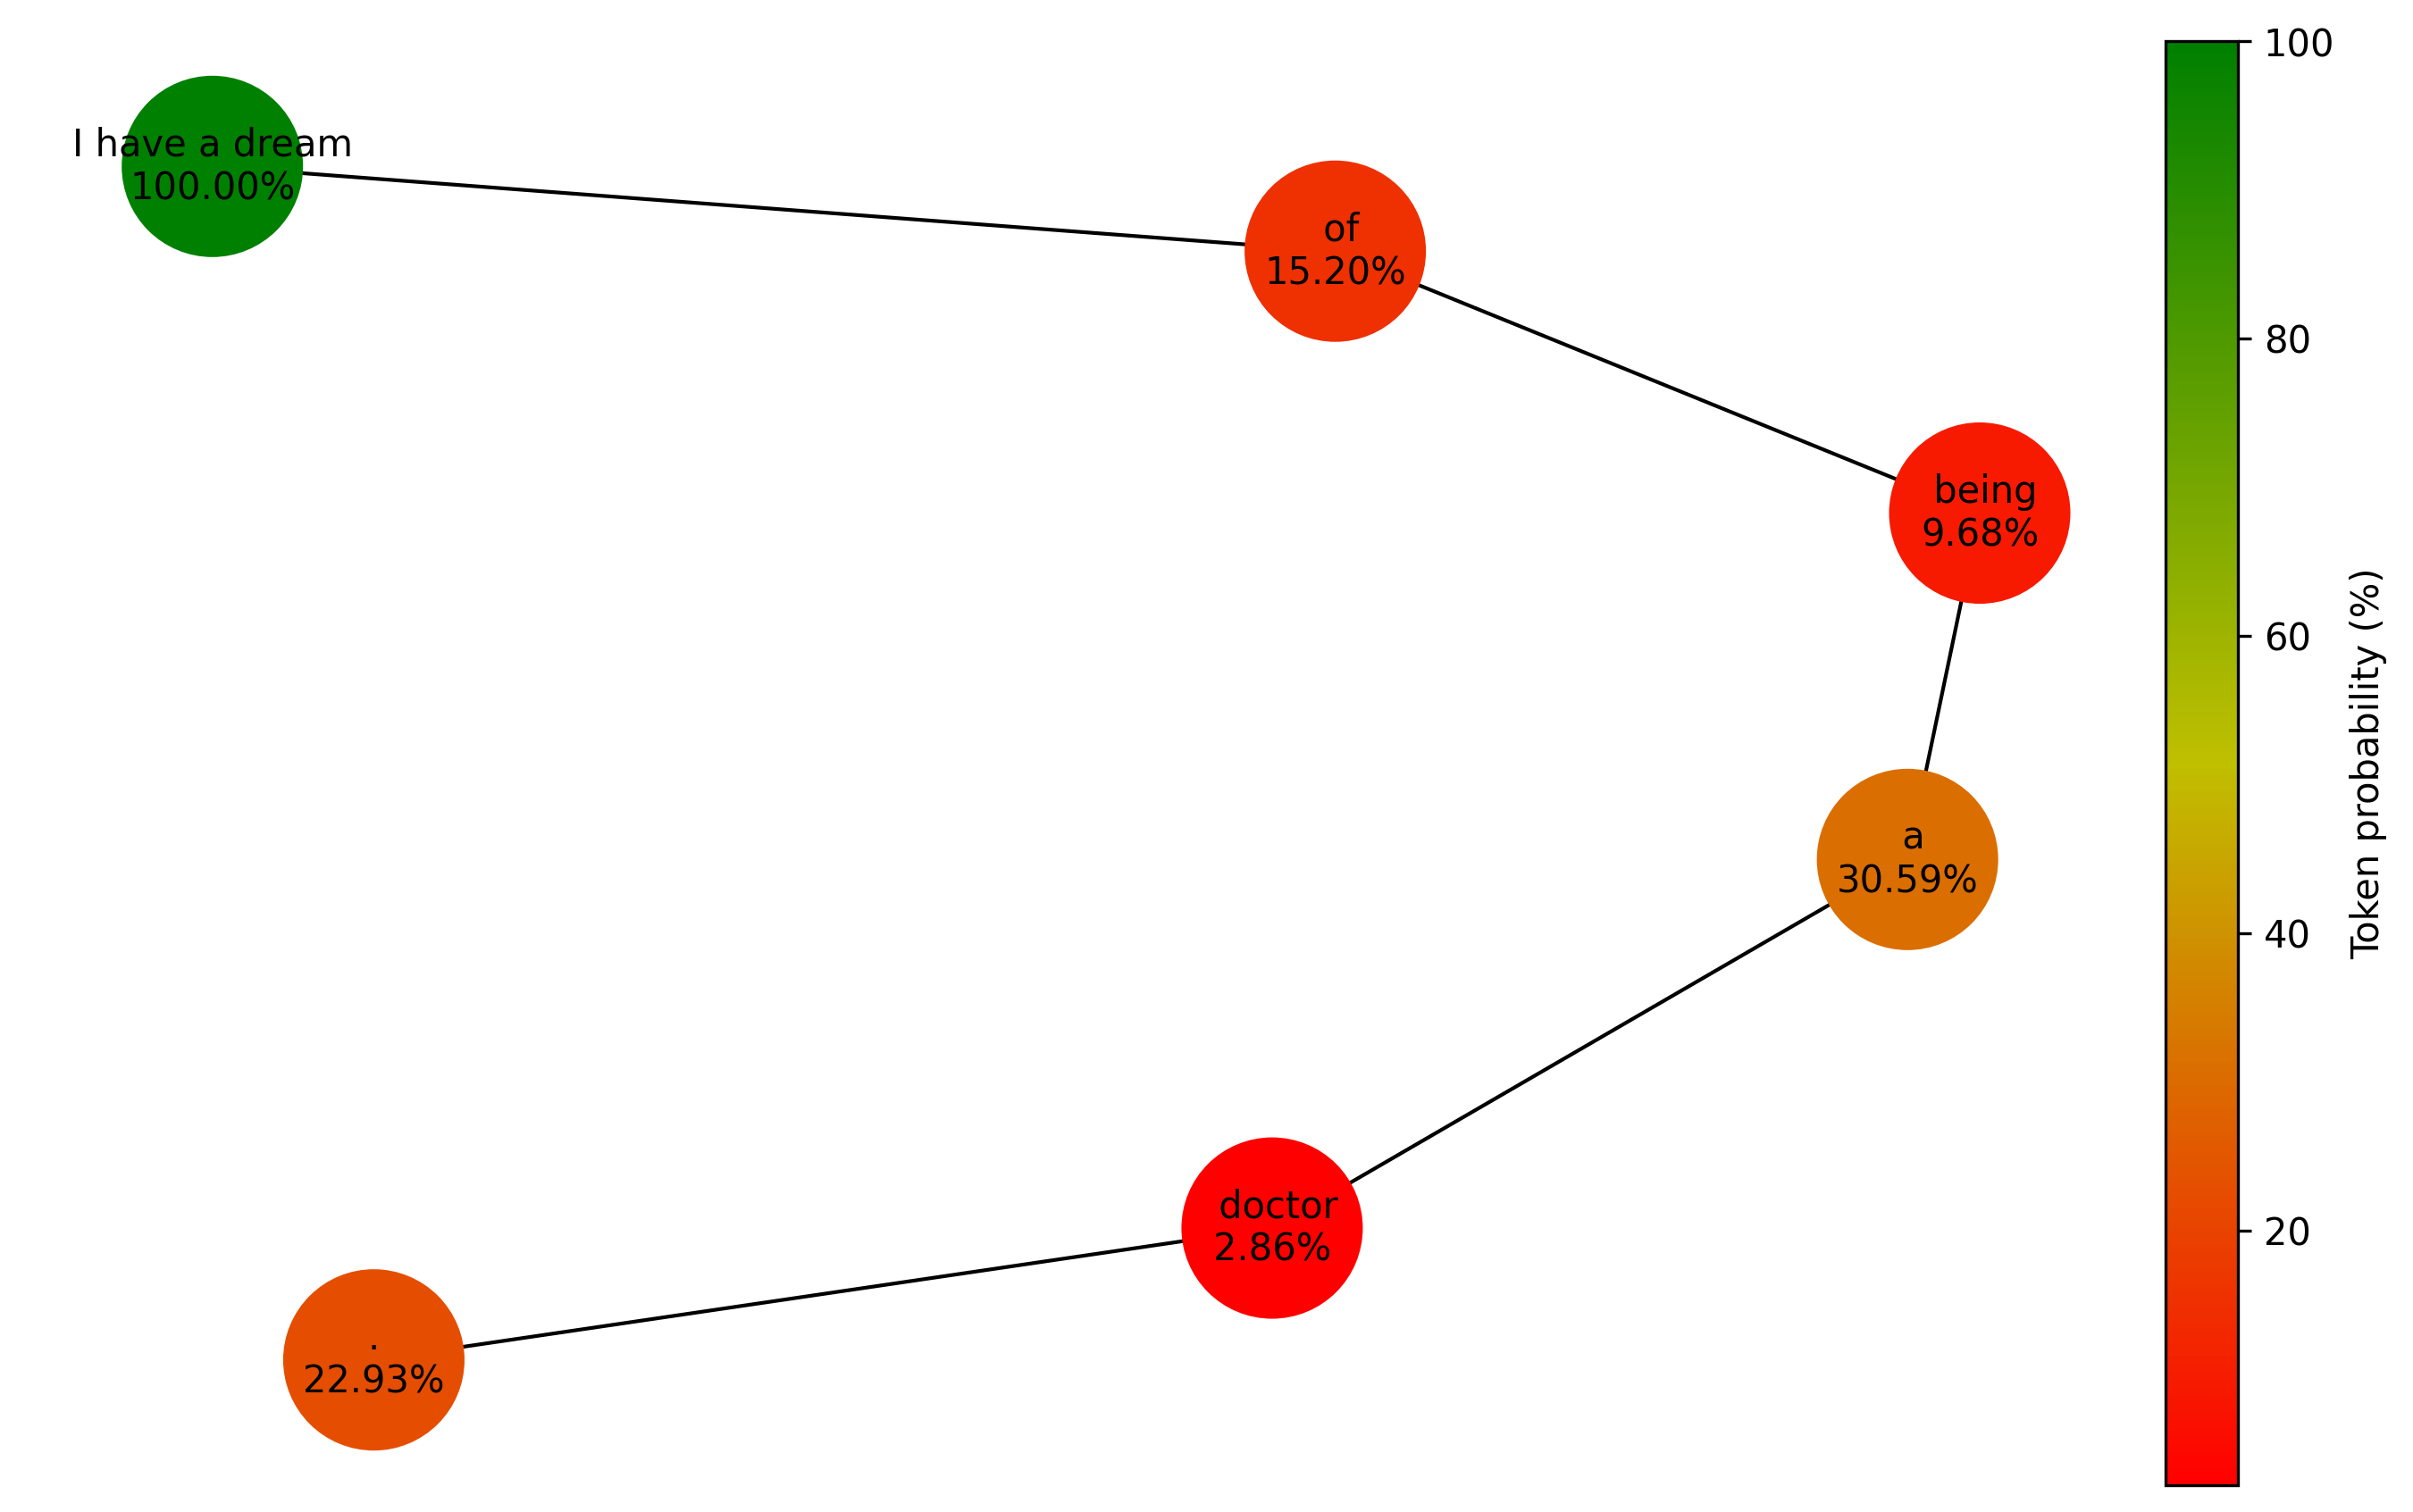

In [20]:
#Visualize the attention
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

def get_log_prob(logits, token_id):
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    log_probabilities = torch.log(probabilities)
    token_log_probability = log_probabilities[token_id].item()
    return token_log_probability

def greedy_search(input_ids, node, length=5):
    if length == 0:
        return input_ids

    outputs = model(input_ids)
    predictions = outputs.logits

    logits = predictions[0, -1, :]
    token_id = torch.argmax(logits).unsqueeze(0)

    token_score = get_log_prob(logits, token_id)
    new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0)], dim=-1)

    next_token = tokenizer.decode(token_id, skip_special_tokens=True)
    current_node = list(graph.successors(node))[0]
    graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
    graph.nodes[current_node]['token'] = next_token + f"_{length}"

    input_ids = greedy_search(new_input_ids, current_node, length-1)
    
    return input_ids

length = 5
beams = 1
graph = nx.balanced_tree(1, length, create_using=nx.DiGraph())

for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['token'] = text

output_ids = greedy_search(input_ids, 0, length=length)
output = tokenizer.decode(output_ids.squeeze().tolist(), skip_special_tokens=True)
print(f"Generated text: {output}")

import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def plot_graph(graph, length, beams, score):
    fig, ax = plt.subplots(figsize=(3+1.2*beams**length, max(5, 2+length)), dpi=300, facecolor='white')
    pos = nx.spring_layout(graph)
    scores = [data['tokenscore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256) 

    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_shape='o', alpha=1, linewidths=4, 
                          node_color=scores, cmap=cmap)
    nx.draw_networkx_edges(graph, pos)
    labels = {node: data['token'].split('_')[0] + f"\n{data['tokenscore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.box(False)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Token probability (%)')
    plt.show()

plot_graph(graph, length, 1.5, 'token')



Beam Search:

    Mechanism: Considers multiple beams (sequences) at each step and keeps the top n beams based on their cumulative probabilities.
    Pros: Balances between probability and sequence quality.
    Cons: Computationally expensive and can still miss diverse sequences.

  0%|          | 0/63 [00:00<?, ?it/s]

Generated text: I have a dream. I have a dream


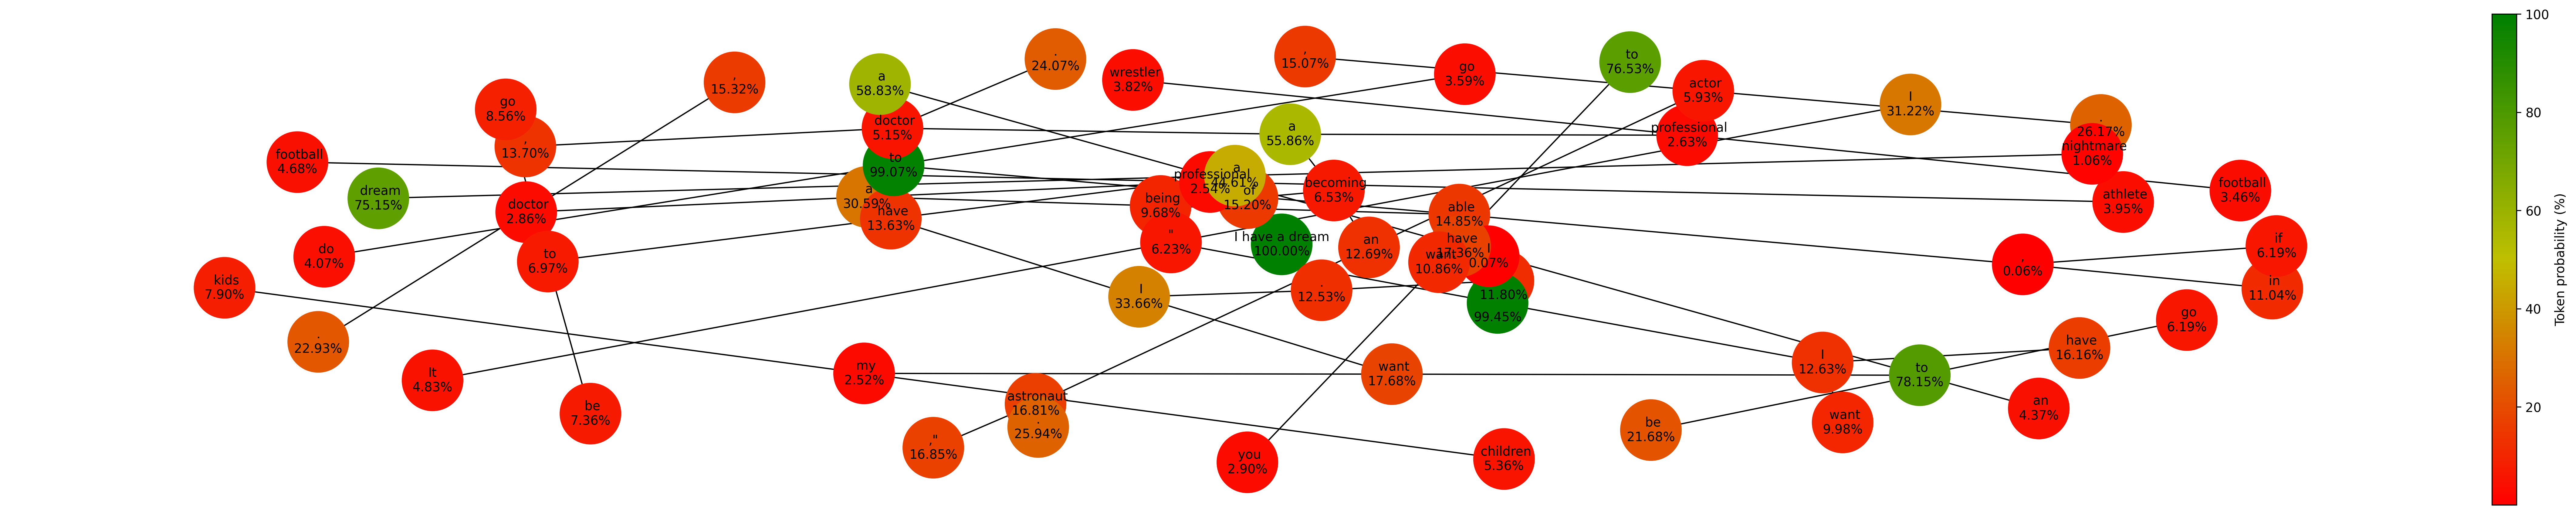

In [21]:

from tqdm.notebook import tqdm

def greedy_sampling(logits, beams):
    return torch.topk(logits, beams).indices

def beam_search(input_ids, node, bar, length, beams, sampling, temperature=0.1):
    if length == 0:
        return None

    outputs = model(input_ids)
    predictions = outputs.logits

    logits = predictions[0, -1, :]

    if sampling == 'greedy':
        top_token_ids = greedy_sampling(logits, beams)
    elif sampling == 'top_k':
        top_token_ids = top_k_sampling(logits, temperature, 20, beams)
    elif sampling == 'nucleus':
        top_token_ids = nucleus_sampling(logits, temperature, 0.5, beams)

    for j, token_id in enumerate(top_token_ids):
        bar.update(1)

        token_score = get_log_prob(logits, token_id)
        cumulative_score = graph.nodes[node]['cumscore'] + token_score

        new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=-1)

        token = tokenizer.decode(token_id, skip_special_tokens=True)
        current_node = list(graph.successors(node))[j]
        graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
        graph.nodes[current_node]['cumscore'] = cumulative_score
        graph.nodes[current_node]['sequencescore'] = 1/(len(new_input_ids.squeeze())) * cumulative_score
        graph.nodes[current_node]['token'] = token + f"_{length}_{j}"

        beam_search(new_input_ids, current_node, bar, length-1, beams, sampling, 1)

length = 5
beams = 2
graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph())
bar = tqdm(total=len(graph.nodes))

for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['cumscore'] = 0
    graph.nodes[node]['sequencescore'] = 0
    graph.nodes[node]['token'] = text

beam_search(input_ids, 0, bar, length, beams, 'greedy', 1)


#Visualize the beam search
def get_best_sequence(G):
    leaf_nodes = [node for node in G.nodes() if G.out_degree(node)==0]
    max_score_node = None
    max_score = float('-inf')
    for node in leaf_nodes:
        if G.nodes[node]['sequencescore'] > max_score:
            max_score = G.nodes[node]['sequencescore']
            max_score_node = node

    path = nx.shortest_path(G, source=0, target=max_score_node)
    sequence = "".join([G.nodes[node]['token'].split('_')[0] for node in path])
    
    return sequence, max_score

sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

plot_graph(graph, length, beams, 'sequence')

Top-k Sampling:

    Mechanism: Randomly selects the next token from the top k most probable tokens.
    Pros: Introduces randomness, which can lead to more creative outputs.
    Cons: Can produce less coherent sequences.

Generated text: I have a dream.

When I


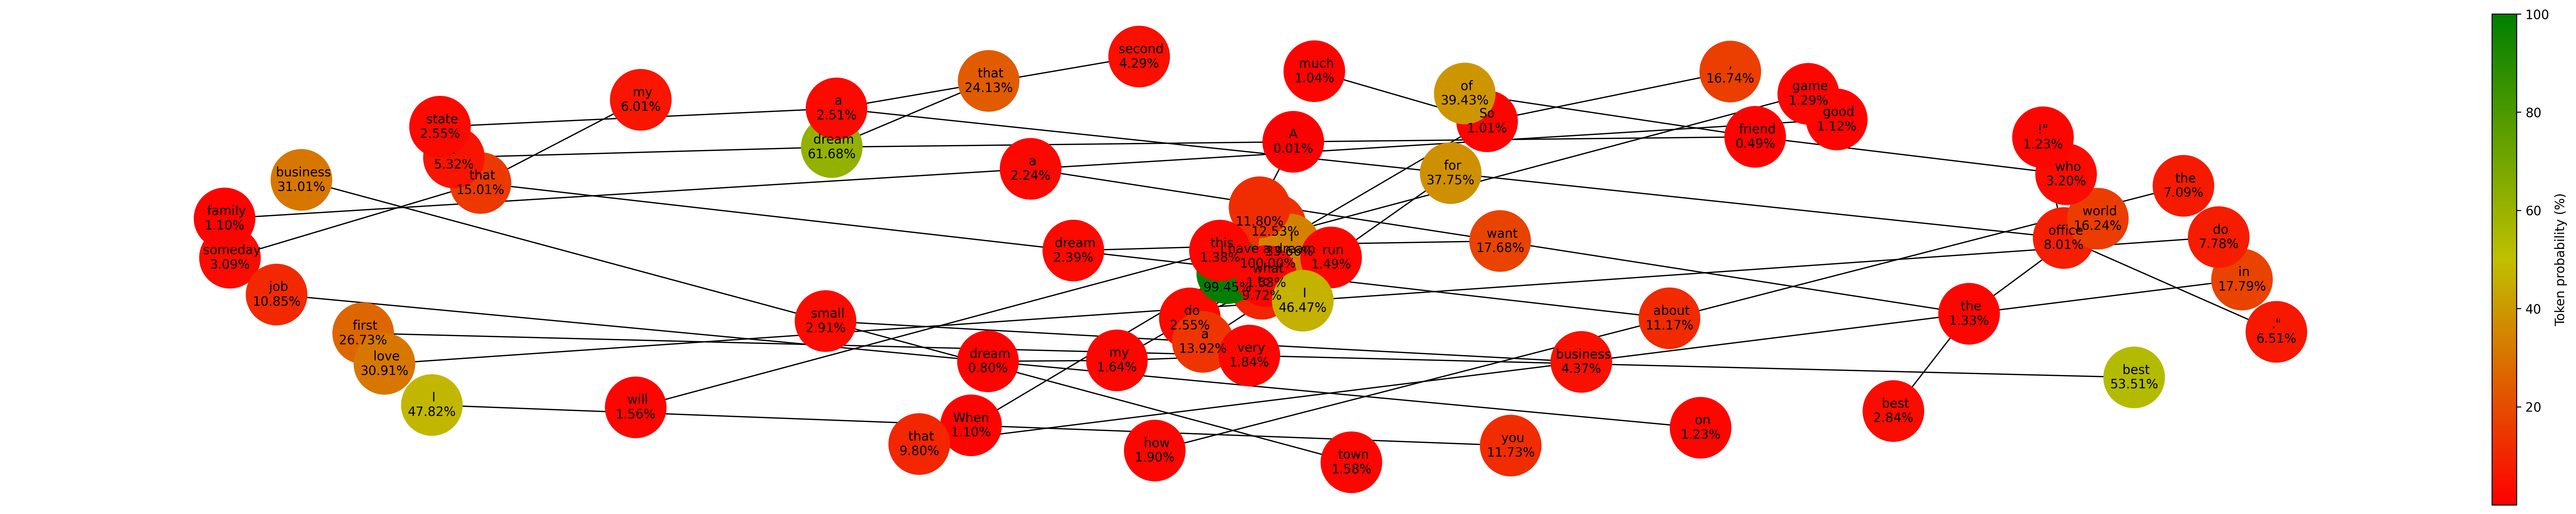

In [22]:

def top_k_sampling(logits, temperature, top_k, beams, plot=True):
    assert top_k >= 1
    assert beams <= top_k

    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    new_logits = torch.clone(logits)
    new_logits[indices_to_remove] = float('-inf')
    probabilities = torch.nn.functional.softmax(new_logits / temperature, dim=-1)
    next_tokens = torch.multinomial(probabilities, beams)

    return next_tokens

beam_search(input_ids, 0, bar, length, beams, 'top_k', 1)

#Visualize the top-k sampling
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

plot_graph(graph, length, beams, 'sequence')

Nucleus Sampling (Top-p Sampling):

    Mechanism: Chooses tokens from a nucleus of tokens whose cumulative probability exceeds a threshold p.
    Pros: Balances randomness with coherence, leading to more natural outputs.
    Cons: More complex to implement.

Generated text: I have a dream. I have a dream


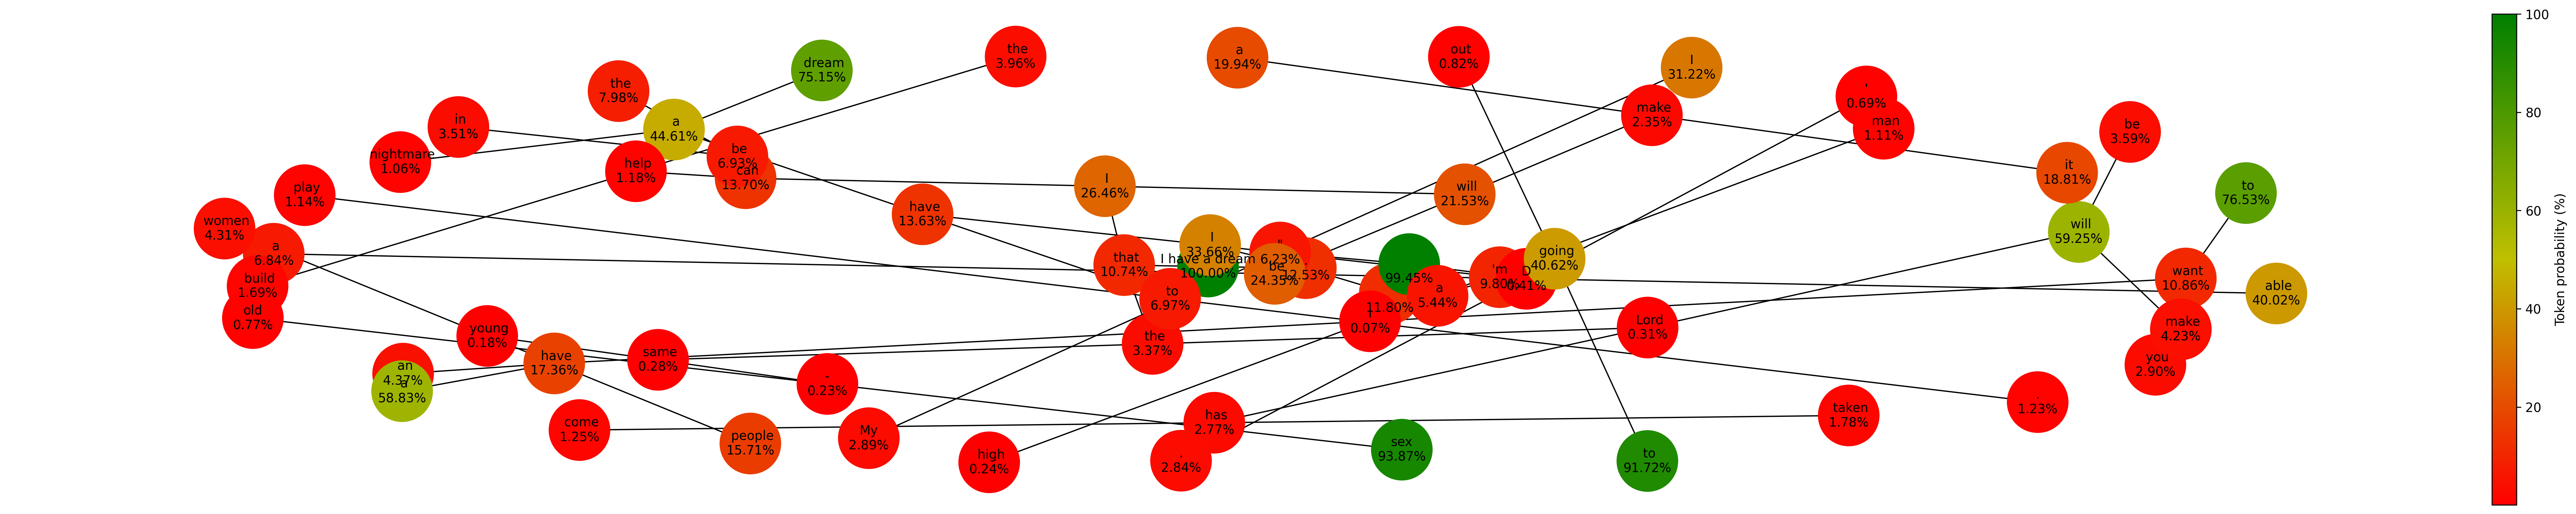

In [23]:

def nucleus_sampling(logits, temperature, p, beams, plot=True):
    assert p > 0
    assert p <= 1

    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    cumulative_probabilities = torch.cumsum(probabilities, dim=-1)

    mask = cumulative_probabilities < p
    if mask.sum() > beams:
        top_p_index_to_keep = torch.where(mask)[0][-1].detach().cpu().tolist()
    else:
        top_p_index_to_keep = beams

    indices_to_remove = sorted_indices[top_p_index_to_keep:]
    sorted_logits[indices_to_remove] = float('-inf')
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    next_tokens = torch.multinomial(probabilities, beams)

    return next_tokens

beam_search(input_ids, 0, bar, length, beams, 'nucleus', 1)

#Visualize the nucleus sampling
sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence}")

plot_graph(graph, length, beams, 'sequence')


Conclusion:

    Understanding different decoding strategies is crucial for guiding LLMs to produce realistic, nuanced, and compelling text.
    Greedy search is straightforward but can miss better sequences.
    Beam search balances probability and sequence quality but is computationally intensive.
    Top-k sampling introduces randomness and creativity.
    Nucleus sampling provides a balance between randomness and coherence, producing more natural outputs.